In [2]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install qiskit_machine_learning
!{sys.executable} -m pip install pylatexenc

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import providers
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('titanic_dataset/train.csv') # read csv file as pandas data frame
df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [3]:
feature_name_list = list(df)
list(feature_name_list)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [4]:
df_selected = df[[ 'Pclass', 'Survived','Age', 'Sex', 'Parch']] # Choose desired features and labels(classes)
df_selected

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
886,2,0,27.0,male,0
887,1,1,19.0,female,0
888,3,0,NaN,female,2
889,1,1,26.0,male,0


In [5]:
print('Total empty values in the Dataset :', df_selected.isnull().sum().sum())
clean_data = df_selected.dropna()
#print('Total empty values in the Dataset :', clean_data.isnull().sum().sum())

Total empty values in the Dataset : 177


In [6]:
for col in clean_data.columns:
        print('Unique values in {} :'.format(col),len(clean_data[col].unique()))

Unique values in Pclass : 3
Unique values in Survived : 2
Unique values in Age : 88
Unique values in Sex : 2
Unique values in Parch : 7


In [7]:
clean_data

,Pclass,Survived,Age,Sex,Parch
0,3,0,22.0,male,0
1,1,1,38.0,female,0
2,3,1,26.0,female,0
3,1,1,35.0,female,0
4,3,0,35.0,male,0
...,...,...,...,...,...
885,3,0,39.0,female,5
886,2,0,27.0,male,0
887,1,1,19.0,female,0
889,1,1,26.0,male,0


In [8]:
print('Unique values in updated Gender column :', clean_data.Sex.unique())
print('Range of column Age :', (clean_data.Age.min(), clean_data.Age.max()))
print('Unique values in parent/child column :', clean_data.Parch.unique())
print('Unique values in passenger class column :', clean_data.Pclass.unique())

clean_data['Sex'].replace(to_replace = 'male', value = 0, inplace=True)
clean_data['Sex'].replace(to_replace = 'female', value = 1, inplace=True)

Unique values in updated Gender column : ['male' 'female']
Range of column Age : (0.42, 80.0)
Unique values in parent/child column : [0 1 2 5 3 4 6]
Unique values in passenger class column : [3 1 2]


In [9]:
# Define features and labels (that contin class information)
test_ratio = 0.2
seed = 1430
np.random.seed(seed)
X = np.array(clean_data.drop('Survived', axis =1)) # X contains all feature values as array
y = np.array(clean_data.Survived) # y contains class values as array
X = preprocessing.normalize(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)

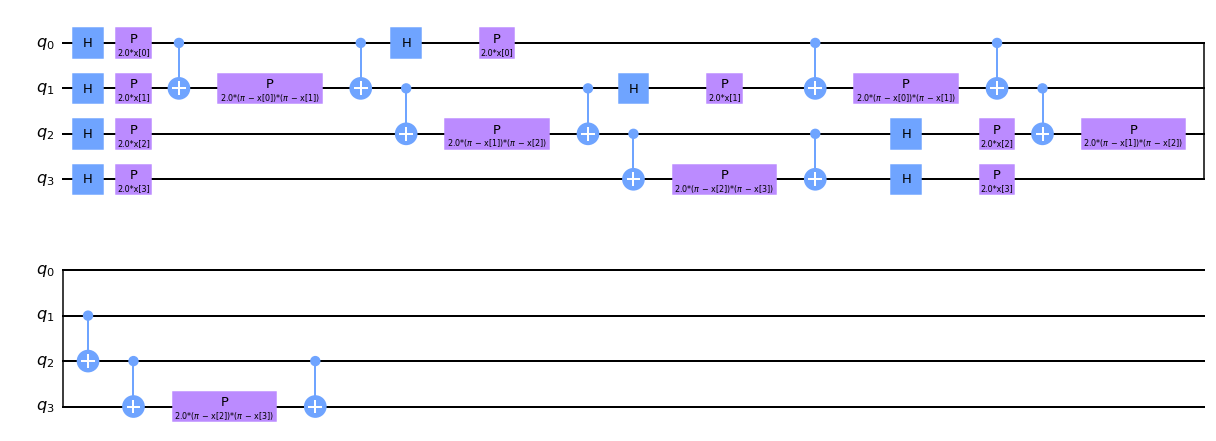

In [10]:
feature_dim = X.shape[1]
feature_map_rep = 2
ent = 'linear'

fmap_zz = ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)
fmap_zz.decompose().draw('mpl', scale=1)

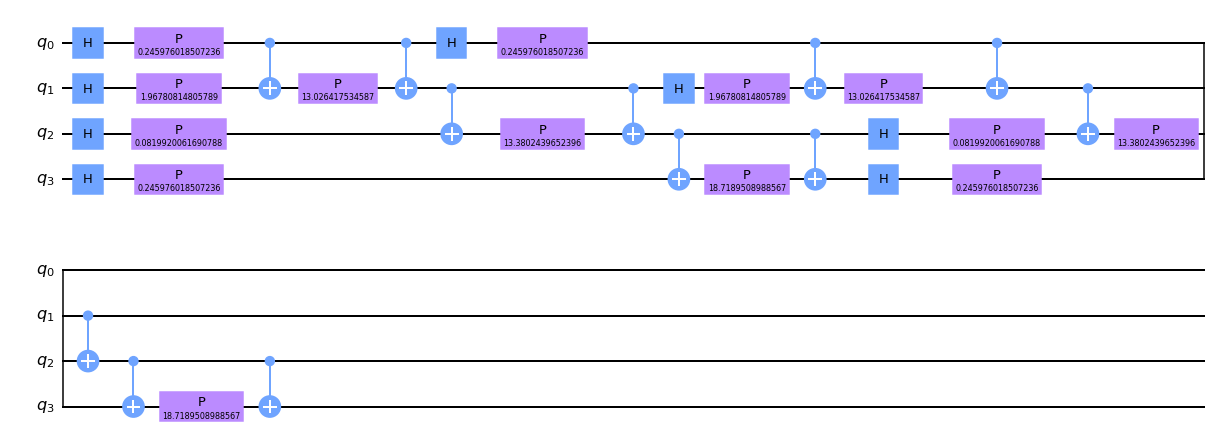

In [11]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

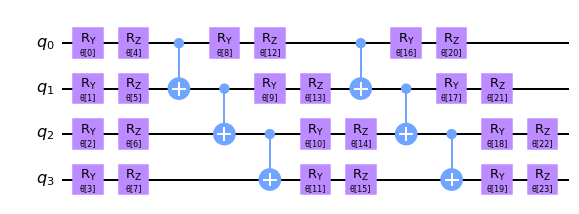

In [12]:
rotations = ['ry', 'rz']
var_form_rep = 2


ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

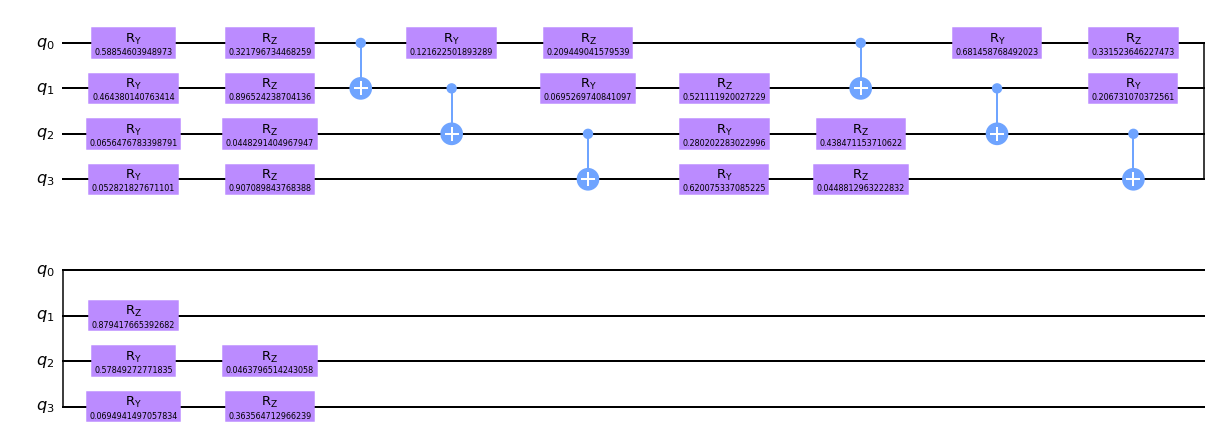

In [13]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

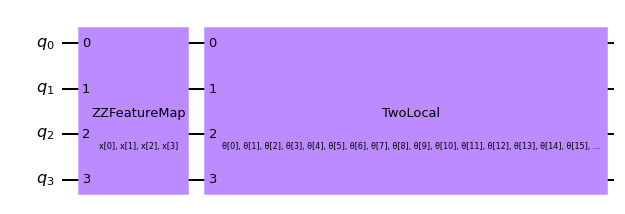

In [14]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [15]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [20]:
providers.aer.StatevectorSimulator().available_devices()

('CPU',)

In [21]:
statevec_sim = providers.aer.StatevectorSimulator(max_parallel_threads = 16, max_parallel_experiments=0)

In [22]:
# qasm_sim = qiskit.providers.aer.QasmSimulator(method=)
#qasm_sim = Aer.get_backend('qasm_simulator')
# qinst = QuantumInstance(qasm_sim, 2048)
qinst = QuantumInstance(statevec_sim, 2048)

In [23]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [24]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.77213801, 0.22786199]])

In [25]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[-2.11072872e-01,  4.11144017e-02, -1.49110590e-01,
         -9.36750677e-17,  2.94882973e-02, -9.78388566e-04,
         -7.23955932e-02, -2.08166817e-17,  1.53059853e-01,
         -6.91331770e-03,  6.24500451e-17,  5.03069808e-17,
          1.60221628e-02, -3.68086068e-02, -6.93889390e-18,
          4.16333634e-17, -2.65574613e-01,  6.59194921e-17,
          2.77555756e-17, -7.97972799e-17,  9.02056208e-17,
         -1.73472348e-17,  1.14491749e-16,  6.93889390e-17],
        [ 2.11072872e-01, -4.11144017e-02,  1.49110590e-01,
         -2.08166817e-17, -2.94882973e-02,  9.78388566e-04,
          7.23955932e-02, -3.03576608e-17, -1.53059853e-01,
          6.91331770e-03, -1.21430643e-17,  4.16333634e-17,
         -1.60221628e-02,  3.68086068e-02,  1.38777878e-17,
         -1.04083409e-17,  2.65574613e-01,  1.04083409e-17,
          1.38777878e-17, -6.93889390e-18,  4.95480393e-17,
         -9.10729825e-18,  7.37257477e-18,  1.99493200e-17]]])

In [26]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [27]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [28]:
max_itr = 500
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 560.1738326021982
6 - 561.7722741207854
9 - 556.944700918463
12 - 556.3173178228608
15 - 556.0807724552709
18 - 552.2553000530183
21 - 552.1631900656582
24 - 551.3414660972096
27 - 550.2745661032889
30 - 548.5459426991376
33 - 548.5481039931693
36 - 547.6867665070024
39 - 545.7653808614864
42 - 542.3456020581182
45 - 542.1746369891812
48 - 541.5651925230648
51 - 539.6000939825935
54 - 537.4061689417
57 - 535.4347073019533
60 - 535.3532011395396
63 - 535.1432217620267
66 - 532.6243285870503
69 - 532.3050928526088
72 - 531.0298863859084
75 - 530.4009178440936
78 - 530.2082332672367
81 - 529.9793112860455
84 - 529.8900677031855
87 - 529.8007533552397
90 - 528.1322736666237
93 - 527.7639596556762
96 - 527.0891018977289
99 - 526.6277986079685
102 - 525.399745131846
105 - 525.4027336604099
108 - 524.9771132769285
111 - 524.3031904816105
114 - 522.8391004673481
117 - 522.7144938635699
120 - 521.8105077857408
123 - 521.752656249351
126 - 520.3460451052899
129 - 520.3363300939675
132 - 520.

In [29]:
score_train = vqc.score(x_train_norm, y_train_1h)
score_test = vqc.score(x_test_norm, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.6304728546409807
Score on the test set 0.6503496503496503


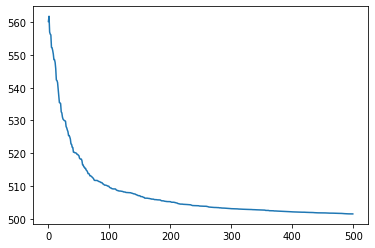

In [30]:
plt.plot(loss_recorder)

In [ ]:
shots = 1024
quantum_computer = 'Simulator'# 'Simulator' or 'RealComputer'

if quantum_computer == 'Simulator':
    qasm_sim = Aer.get_backend('qasm_simulator')
    qinst = QuantumInstance(qasm_sim, shots)
    
else:
# run on real quantum computer    
    IBMQ.save_account(open("/home/aaltintas/Dropbox/quantum-computing/IBM/useIBMlocally.txt").read())    
    IBMQ.load_account()    
    qc_providers = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')   #qc_providers = IBMQ.get_provider("ibm-q")    
    qc_get_computer = qc_providers.get_backend('ibmq_jakarta')
        
    qinst = QuantumInstance(qc_get_computer, shots, seed)   # watch job statusimport qiskit.tools.jupyter

from qiskit.tools.monitor import job_monitor
#%qiskit_job_watcher
#job_executed = execute(qinst, pauli_circuit)
#job_monitor(job_executed)